In [2]:
import numpy as np
from PIL import Image
import taichi as ti
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from utils import run_optimization, resample_polyline, get_area

ti.init(arch=ti.gpu)

[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.12.3
[Taichi] Starting on arch=cuda


(-0.55, 0.55, -0.55, 0.55)

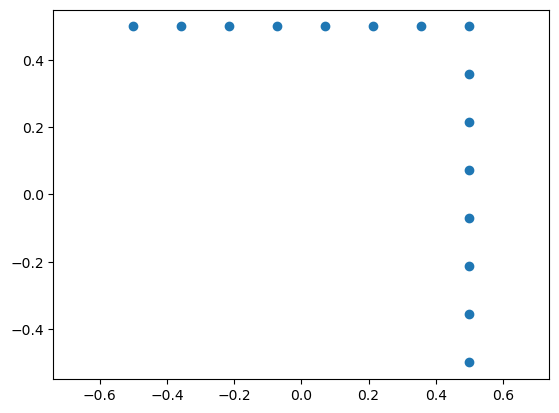

In [41]:
def init_trajectory(sofa_w, sofa_h, control_point_num, middle_rotation=-0.5 * np.pi, offset=1):  # 生成初始轨迹
    xs, ys, rotations = resample_polyline([
        [0.5 - offset, 0.5, 0],
        [0.5, 0.5, 0],
        [0.5, 0.5, middle_rotation],
        [0.5, 0.5 - offset, middle_rotation],
        [0.5, 0.5 - offset, 0]
    ], control_point_num).T
    return xs, ys, rotations

offset = 1  # 前后走廊中线的距离，小于1时沙发无限大

sofa_w = 3.5   # 求解域的尺寸
sofa_h = 1.0   # 求解域的尺寸

xs, ys, rotations = init_trajectory(  # 初始轨迹
    sofa_w=sofa_w,
    sofa_h=sofa_h,
    control_point_num=15,  # 轨迹的控制点数量
    middle_rotation=-0.0 * np.pi,
    offset=offset
)

plt.scatter(xs, ys)
plt.axis('equal')

In [ ]:
# xs, ys, rotations = np.load('../trajectory/双拐角_offset1/sofa_3394.npy')

In [ ]:
# from utils import monotonicly_interpolate

# keys = xs - ys  # 要求这个函数单调递增来重新采样
# xs, ys, rotations = monotonicly_interpolate(
#     keys,
#     np.array([xs, ys, rotations]).T,
#     len(xs) * 2 + 1,
#     key_min=keys[0],
#     key_max=keys[-1]
# ).T

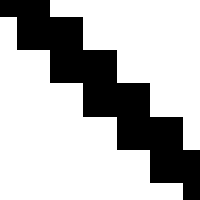

In [ ]:
# 定义哪里是墙

from utils import test_forbidden_function

@ti.func
def is_forbidden(x, y):  # 指定哪里是墙
    return -y - ti.floor(x) < -1 or -y - ti.floor(x) > 1

image = test_forbidden_function(is_forbidden, 0.5 - 3, 0.5 + 3, -0.5 - 3, -0.5 + 3, 200)
Image.fromarray(np.array(image.T[::-1] * 255, dtype=np.uint8))

Initial survivors: 3.5
iter 500 / 200000, maximal_area=3.58563232421875
iter 1000 / 200000, maximal_area=3.62255859375
iter 1500 / 200000, maximal_area=3.65167236328125
iter 2000 / 200000, maximal_area=3.65673828125
iter 2500 / 200000, maximal_area=3.67242431640625
iter 3000 / 200000, maximal_area=3.69219970703125
iter 3500 / 200000, maximal_area=3.69635009765625
iter 4000 / 200000, maximal_area=3.7030029296875
iter 4500 / 200000, maximal_area=3.70849609375
iter 5000 / 200000, maximal_area=3.70928955078125
iter 5500 / 200000, maximal_area=3.71533203125
iter 6000 / 200000, maximal_area=3.7181396484375
iter 6500 / 200000, maximal_area=3.71875
iter 7000 / 200000, maximal_area=3.71875
iter 7500 / 200000, maximal_area=3.71917724609375
iter 8000 / 200000, maximal_area=3.71929931640625
iter 8500 / 200000, maximal_area=3.7193603515625
iter 9000 / 200000, maximal_area=3.71954345703125
iter 9500 / 200000, maximal_area=3.72015380859375
iter 10000 / 200000, maximal_area=3.72021484375
iter 10500 / 

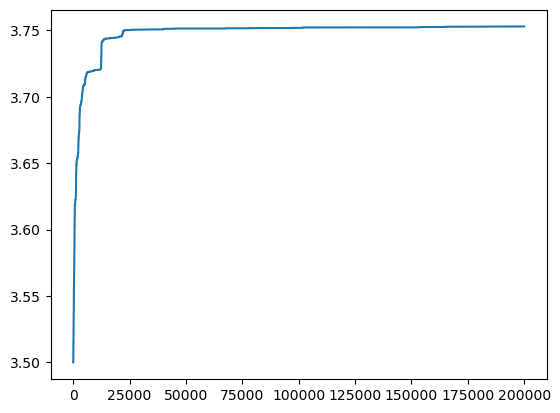

In [ ]:
best_score, xs, ys, rotations, sofa, maximal_area_record = run_optimization(
    is_forbidden,
    xs,
    ys,
    rotations,
    # initial_xs=zoom(xs, zoom=2, order=1),
    # initial_ys=zoom(ys, zoom=2, order=1),
    # initial_rotations=zoom(rotations, zoom=2, order=1),
    sofa_w=4,
    sofa_h=4,
    mutation_sigma_pos = 0.02,  # 变异率
    mutation_sigma_rotation = 0.004,  # 变异率
    iterations = 200000,  # 200000
    trajectory_upsampling=41,  # 41 101
    resolution=512,  # 1024 2000
    print_every=500,  # 1000
    save_image_every=83,
    save_image_path='../images/连续拐角/sofa_',
    save_image_start_id=0,
    save_trajectory_path='../trajectory/连续拐角/sofa_'
)
print(f"Estimated maximal sofa area (by sampling): {best_score:.5f}")
# save mask image as PNG if pillow is available

img = (sofa * 255).astype(np.uint8)
im = Image.fromarray(img.T[::-1])
im.save('sofa_survivors.png')
print('Saved sofa_survivors.png')
plt.plot(maximal_area_record)

连续拐角走廊中沙发的面积是可以无限大的，但我们可以考虑沙发与走廊的面积比。根据数值搜索，这个比的上确界极有可能是$1/2$

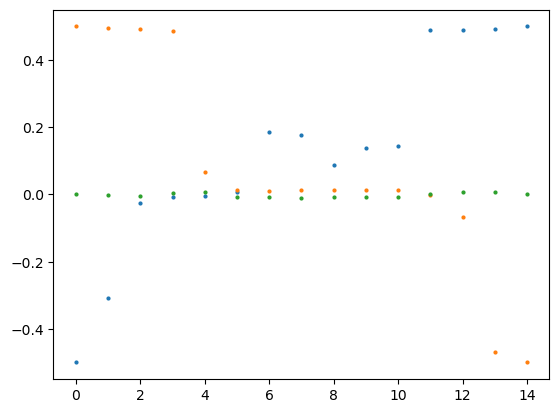

In [43]:
plt.plot(xs, 'o', markersize=2)
plt.plot(ys, 'o', markersize=2)
plt.plot(rotations, 'o', markersize=2)